In [1]:
import os
import numpy as np
import pandas as pd
from os.path import join
from PIL import Image

In [2]:
#分类好的图片
cate_path = "/Users/dqy/My/captcha/label/"

In [3]:
def get_feature(img):
    """
    获取指定图片的特征值,
    根据像素点所形成的矩阵，每一行提取三个特征
    分别是第n次0连续出现的个数，多余三次不计，少于三次计0
    
    :type img: Image
    :return:一个维度为22的列表
    """
    height = 22
    width = 19
    pixel = []
    for y in range(height):
        p = [0,0,0]
        q = [0,0]
        flag = 0
        num = 0
        for x in range(width):
            if num < 3:
                if img.getpixel((x, y)) == 0:
                    p[num] +=1
                    flag = 1
                else:
                    if flag == 1:
                        num +=1
                    flag = 0
        pixel.append(p[0])
        pixel.append(p[1])
        pixel.append(p[2])
    return pixel

In [4]:
def get_bin_table(threshold=190):
    """
    获取灰度转二值的映射table
    :param threshold:
    :return:
    """
    table = []
    for i in range(256):
        if i < threshold:
            table.append(0)
        else:
            table.append(1)

    return table

In [5]:
x = []
y = []

## 获取特征和标签

In [6]:
for fr in os.listdir(cate_path):
        if fr.rfind(u'.DS_Store')==-1:
            for f in os.listdir(cate_path+fr):
                if f.rfind(u'.DS_Store')==-1:
                    image = Image.open(os.path.join(cate_path+fr, f))
                    imgry = image.convert('L')
                    table = get_bin_table()
                    out = imgry.point(table, '1')
                    x.append(get_feature(out)) 
                    y.append(fr)

In [7]:
featureSet = pd.DataFrame(columns=range(len(x[0])))
for i in range(len(x)):    
    featureSet.loc[i] = x[i]

In [8]:
featureSet.tail(5)

,0,1,2,3,4,5,6,7,8,9,...,56,57,58,59,60,61,62,63,64,65
2916,0,0,0,0,0,0,0,0,0,0,...,0,3,3,0,3,3,0,0,0,0
2917,0,0,0,1,0,0,1,0,0,5,...,0,7,6,0,7,6,0,6,6,0
2918,0,0,0,4,5,0,2,2,0,2,...,0,0,0,0,0,0,0,1,0,0
2919,0,0,0,0,0,0,1,1,0,5,...,0,0,0,0,0,0,0,0,0,0
2920,0,0,0,6,6,0,6,6,0,3,...,0,0,0,0,0,0,0,0,0,0


In [9]:
from sklearn.model_selection import train_test_split
from sklearn import svm
import sklearn
from sklearn.metrics import confusion_matrix

## 训练并打印准确率和召回率

In [10]:
X = featureSet.values
X_train, X_test, y_train, y_test = train_test_split(X, y ,test_size=0.1)
clf=svm.SVC(kernel='linear')
clf.fit(X_train,y_train)
y_pro = clf.predict(X_test)
print("Accuracy rate : %f" % (sklearn.metrics.accuracy_score(y_test, y_pro)))
print('Recall rate : %f' % (sklearn.metrics.recall_score(y_test, y_pro,average='macro')))

Accuracy rate : 0.870307
Recall rate : 0.870767


In [11]:
def get_crop_imgs(img):
    child_img_list = []
    for i in range(4):
        x = i * 19 
        y = 0
        child_img = img.crop((x, y, x + 19, img.height))
        child_img_list.append(child_img)
    return child_img_list

In [12]:
def depoint(img):   #input: gray image
    pixdata = img.load()
    w,h = img.size
    for y in range(1,h-1):
        for x in range(1,w-1):
            count = 0
            if pixdata[x,y-1] > 250:
                count = count + 1
            if pixdata[x,y+1] > 250:
                count = count + 1
            if pixdata[x-1,y] > 250:
                count = count + 1
            if pixdata[x+1,y] > 250:
                count = count + 1
            if count > 2:
                pixdata[x,y] = 255
    return img

## 测试

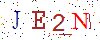

In [13]:
x_pre = []
y_pre = []
image = Image.open("test.png")
image

In [14]:
width, height = image.size
image = image.crop([width/9,height/4,width*8/9,height*4/5])
imgry = image.convert('L')
out = depoint(imgry)
out = imgry.point(table, '1')
pics = get_crop_imgs(out)

In [15]:
for i in pics:
    x_pre.append(get_feature(i))
result = pd.DataFrame(columns=range(len(x_pre[0])))
for i in range(len(x_pre)):    
    result.loc[i] = x_pre[i]
X_pre = featureSet.values
y_pre = clf.predict(result)

In [16]:
''.join(y_pre)

'JE2N'